In [5]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Statistics
include("lattice_BZ.jl")
include("concentrated_BC.jl")

state_coefficients (generic function with 1 method)

In [6]:
function c_hopping_ham(delta, phi)
    return [0 delta * exp(im * phi) conj(delta) * exp(-im * phi); 
    conj(delta) * exp(-im * phi) 0 delta * exp(im * phi); 
    delta * exp(im * phi) conj(delta) * exp(-im * phi) 0]
end

c_hopping_ham (generic function with 1 method)

In [7]:
function c_hopping_plot(delta)
    phi_list = range(0, 2*pi, 100)
    gs_coeffs = Array{ComplexF64}(undef, length(phi_list), 3)
    eigenvalues = Array{Float64}(undef, length(phi_list), 3)
    for j in 1:length(phi_list)
       phi = phi_list[j]
       ham = c_hopping_ham(delta, phi)
       gs_coeffs[j, :] = eigvecs(Hermitian(ham))[:, 1]
       eigenvalues[j, :] = eigvals(Hermitian(ham))
    end


   # create plot
   P = Figure(size=(2000, 1000), fontsize=30)

   ax1 = Axis(P[1, 1], xlabel = L"\varphi", ylabel = L"{|C|}^2")
   lines!(ax1, phi_list, abs.(gs_coeffs[:, 1]).^2, label = L"C_1")
   lines!(ax1, phi_list, abs.(gs_coeffs[:, 2]).^2, label = L"C_2")
   lines!(ax1, phi_list, abs.(gs_coeffs[:, 3]).^2, label = L"C_3")

   P[1, 2] = Legend(P, ax1, framevisible = true)



   ax1 = Axis(P[2, 1], xlabel = L"\varphi", ylabel = L"Arg(\frac{C_{2/3}}{C_1})")
   lines!(ax1, phi_list, angle.(gs_coeffs[:, 2] ./ gs_coeffs[:, 1]) ./ pi, label = L"C_2")
   lines!(ax1, phi_list, angle.(gs_coeffs[:, 3] ./ gs_coeffs[:, 1]) ./ pi, label = L"C_3")


   P[2, 2] = Legend(P, ax1, framevisible = true)


   ax1 = Axis(P[3, 1], xlabel = L"\varphi", ylabel = L"E")
   lines!(ax1, phi_list, eigenvalues[:, 1], label = L"E_1")
   lines!(ax1, phi_list, eigenvalues[:, 2], label = L"E_2")
   lines!(ax1, phi_list, eigenvalues[:, 3], label = L"E_3")

   P[3, 2] = Legend(P, ax1, framevisible = true)

   ax = Axis(P[:, :], title = L"\text{Evolution of Eigenvectors}", titlegap = 60)
   hidedecorations!(ax, label = false)
   hidespines!(ax)

   P
end


c_hopping_plot (generic function with 1 method)

In [8]:
# parameters
delta = -1

-1

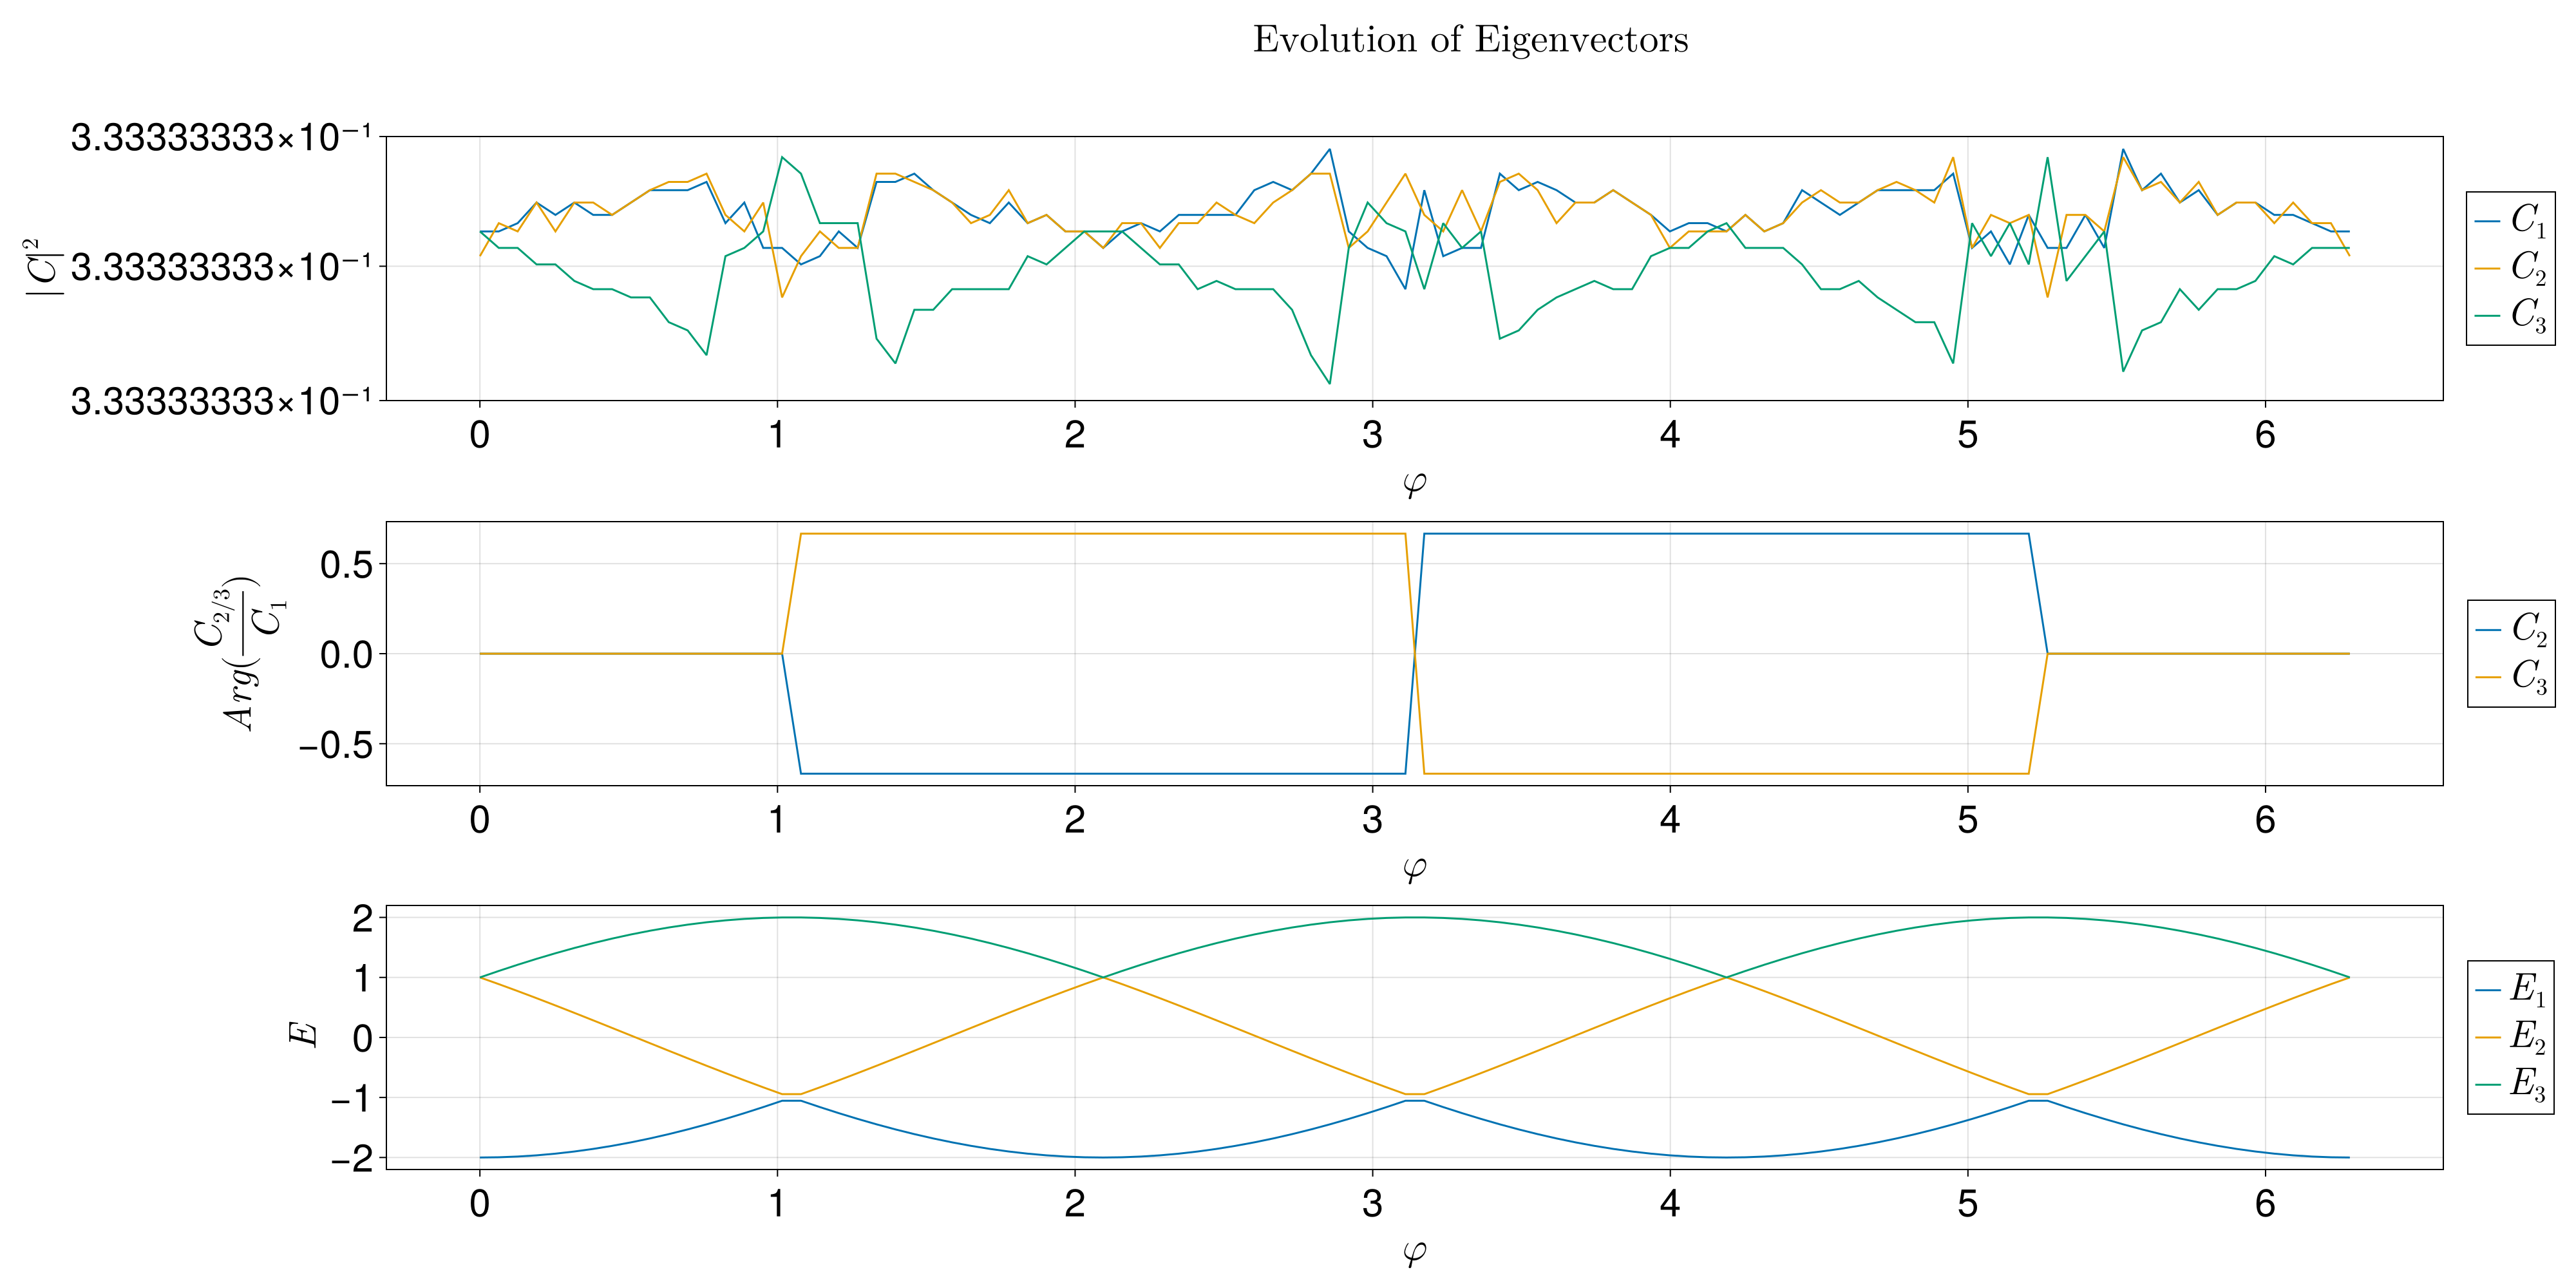

In [9]:
c_hopping_plot(delta)

In [10]:
function plot_energies(delta)
    phi_list = range(0, 2*pi, 100)
    energies = Array{Float64}(undef, length(phi_list), 3)
    for j in 1:length(phi_list)
        phi = phi_list[j]
        energies[j, 1] = -2 * abs(delta) * real(exp(im * phi) * exp(-im * 0 * 2 * pi / 3))
        energies[j, 2] = -2 * abs(delta) * real(exp(im * phi) * exp(-im * 1 * 2 * pi / 3))
        energies[j, 3] = -2 * abs(delta) * real(exp(im * phi) * exp(-im * 2 * 2 * pi / 3))
    end
    # create plot
   P = Figure(size=(2000, 1000), fontsize=30)
   ax1 = Axis(P[1, 1], title = L"\varphi \text{ vs } \epsilon_j", xlabel = L"\varphi", ylabel = L"\epsilon")
   lines!(ax1, phi_list, energies[:, 1], label = L"\epsilon_1")
   lines!(ax1, phi_list, energies[:, 2], label = L"\epsilon_2")
   lines!(ax1, phi_list, energies[:, 3], label = L"\epsilon_3")
   P[1, 2] = Legend(P, ax1, framevisible = true)
   P
end

plot_energies (generic function with 1 method)

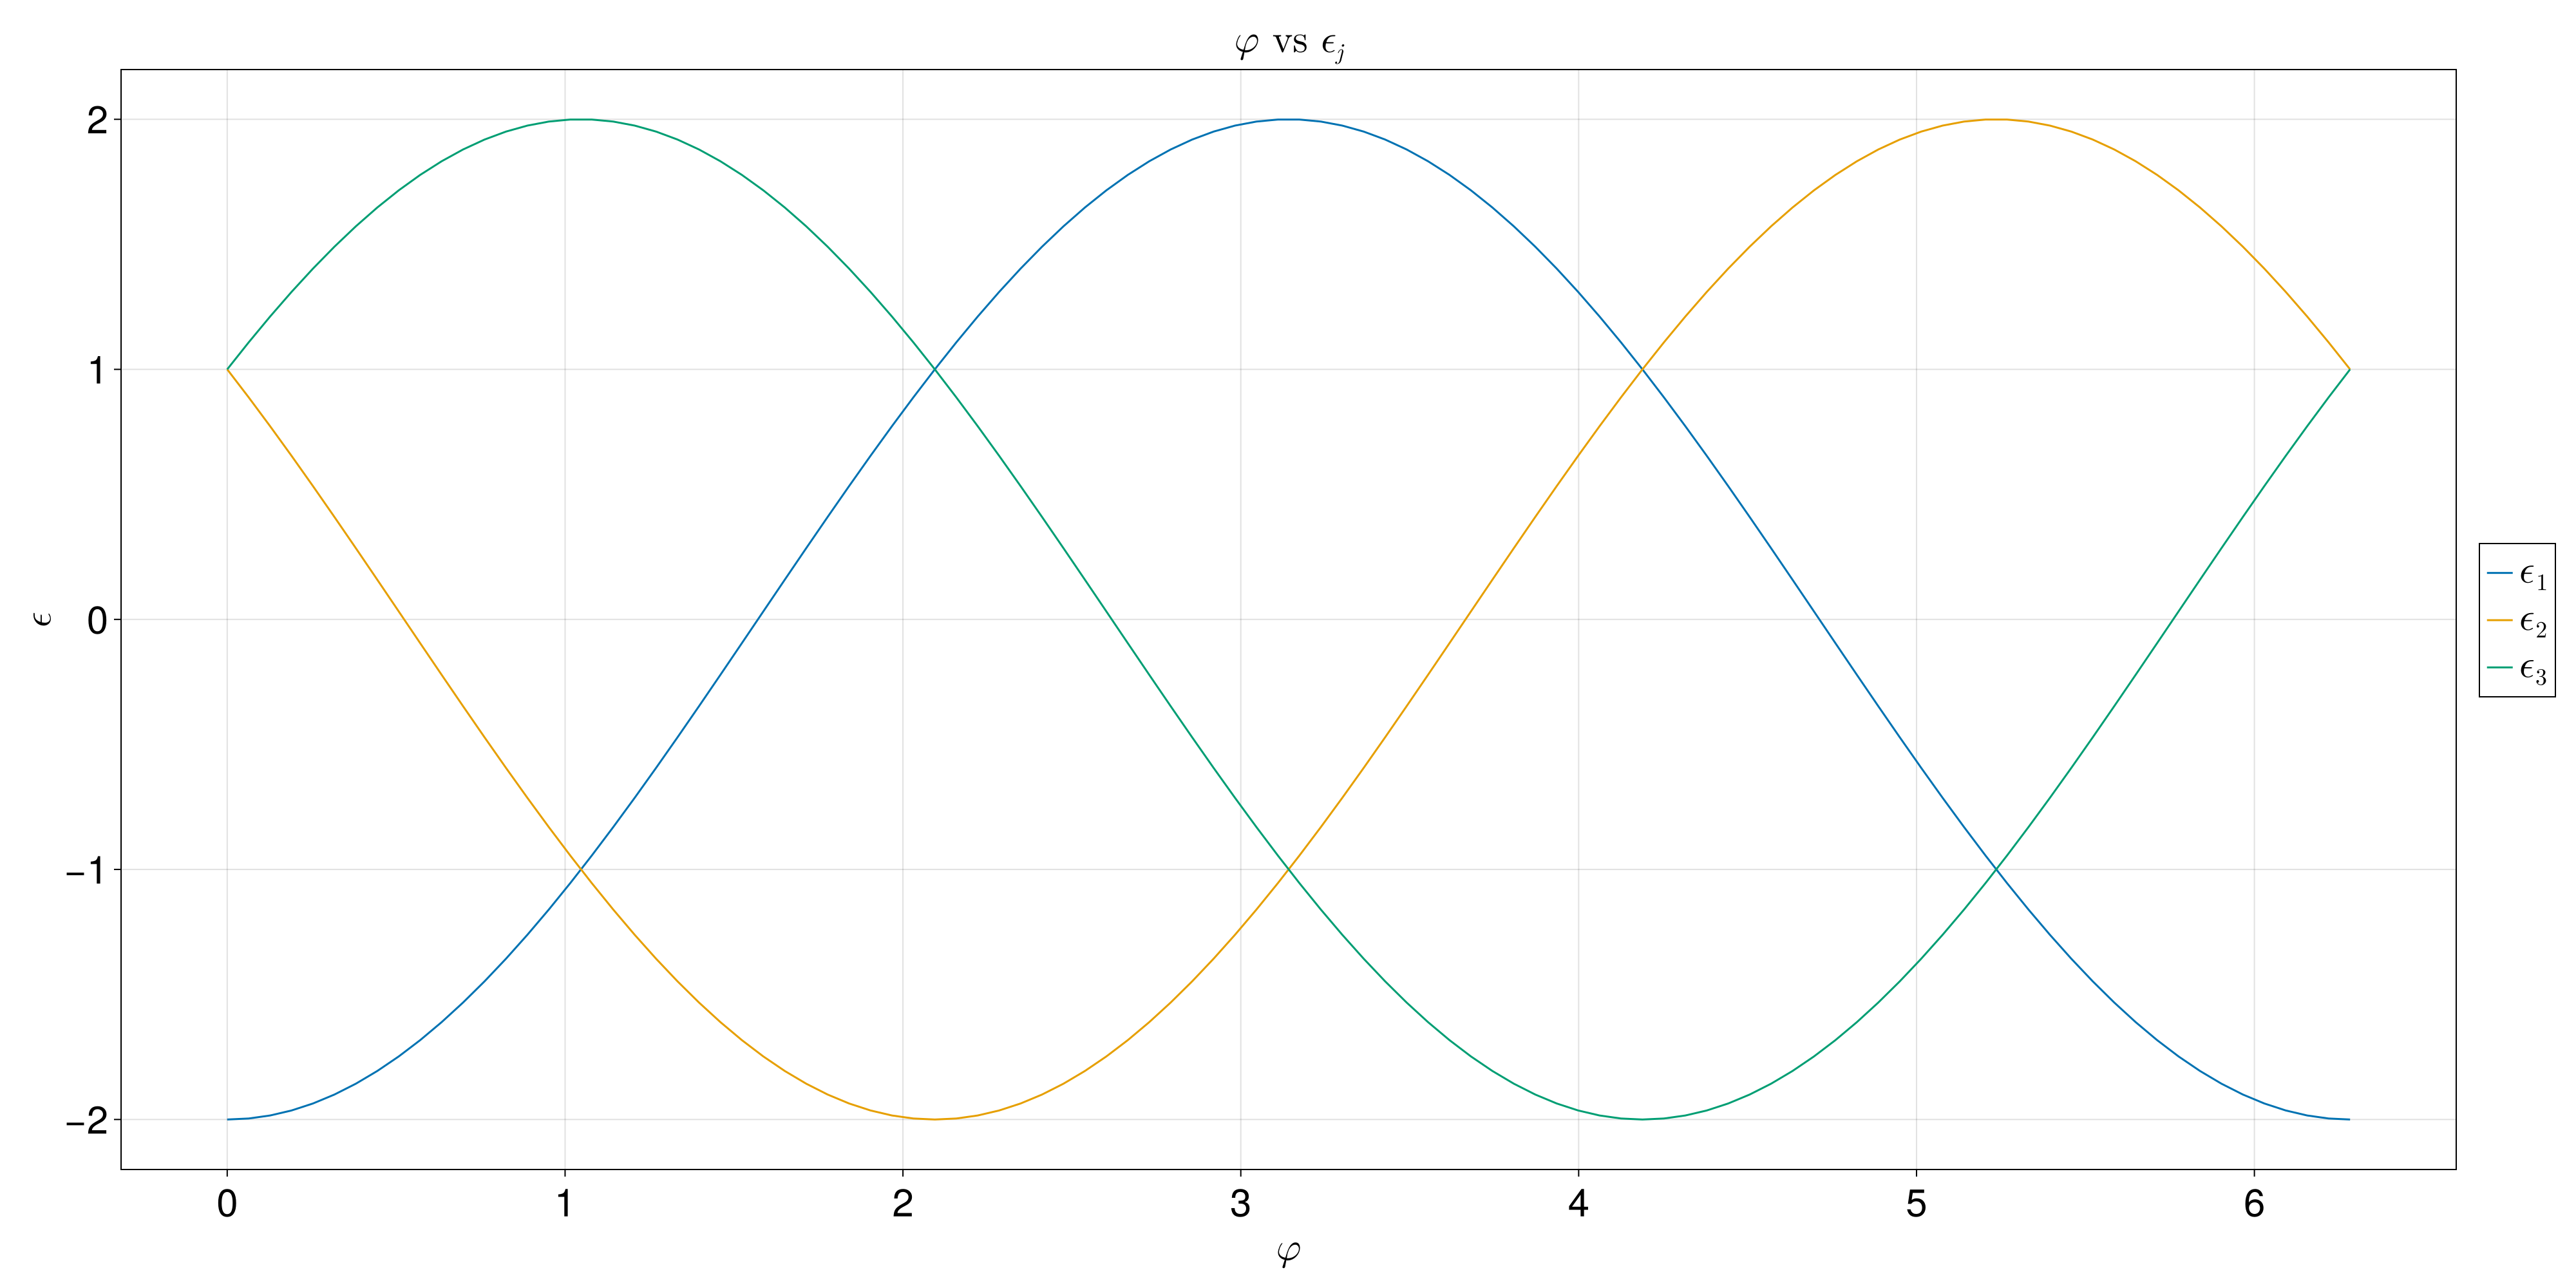

In [11]:
plot_energies(delta)

In [12]:
# Berry curvature over all plaquettes
function c_hop_bc(points, spacing, delta)
    berry_list = Array{Float64}(undef, size(points)[1])
    for i in 1:size(points)[1]
        # get flux through plaquette centered at point
        angles = Array{Float64}(undef, 4)
        states = Array{ComplexF64}(undef, length(angles), 3)
        x0 = points[i, 1]
        y0 = points[i, 2]
        for j in 1:length(angles)
            x_new = x0 + spacing * cos(2 * pi * (j - 1) / length(angles))
            y_new = y0 + spacing * sin(2 * pi * (j - 1) / length(angles))
            phi = polar_angle(x_new, y_new)
            ham = c_hopping_ham(delta, phi)
            states[j, :] = eigvecs(Hermitian(ham))[:, 1]
        end
        P = 1
        for j in 1:length(angles)
            if j < length(angles)
                temp = dot(states[j, :], states[j + 1, :])
                P *= temp
            else
                temp = dot(states[j, :], states[1, :])
                P *= temp
            end
            if temp != 0
                P /= abs(temp)
            end
        end
        berry_list[i] = -angle(P) / area(spacing, length(angles))
    end
    return berry_list
end

c_hop_bc (generic function with 1 method)

In [13]:
function eval_c_hop_bc(qlim, pd, delta)
    spacing = 0.5 * qlim / pd
    grid = make_hex([0, 0], qlim, qlim / pd)
    curvature = c_hop_bc(grid, spacing, delta)

    fig = Figure(size=(800, 600), fontsize=25)
    
    ax1 = Axis(fig[1, 1], title = L"\Omega (\textbf{k})", xlabel = L"k_x", ylabel = L"k_y")
    tricontourf!(ax1, grid[:, 1], grid[:, 2], curvature, colormap = :Spectral)
    X, ax1, tr1 = tricontourf(grid[:, 1], grid[:, 2], curvature, colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)

    fig
end

eval_c_hop_bc (generic function with 1 method)

In [14]:
# parameters
delta = -10
qlim = 1
pd = 50

50

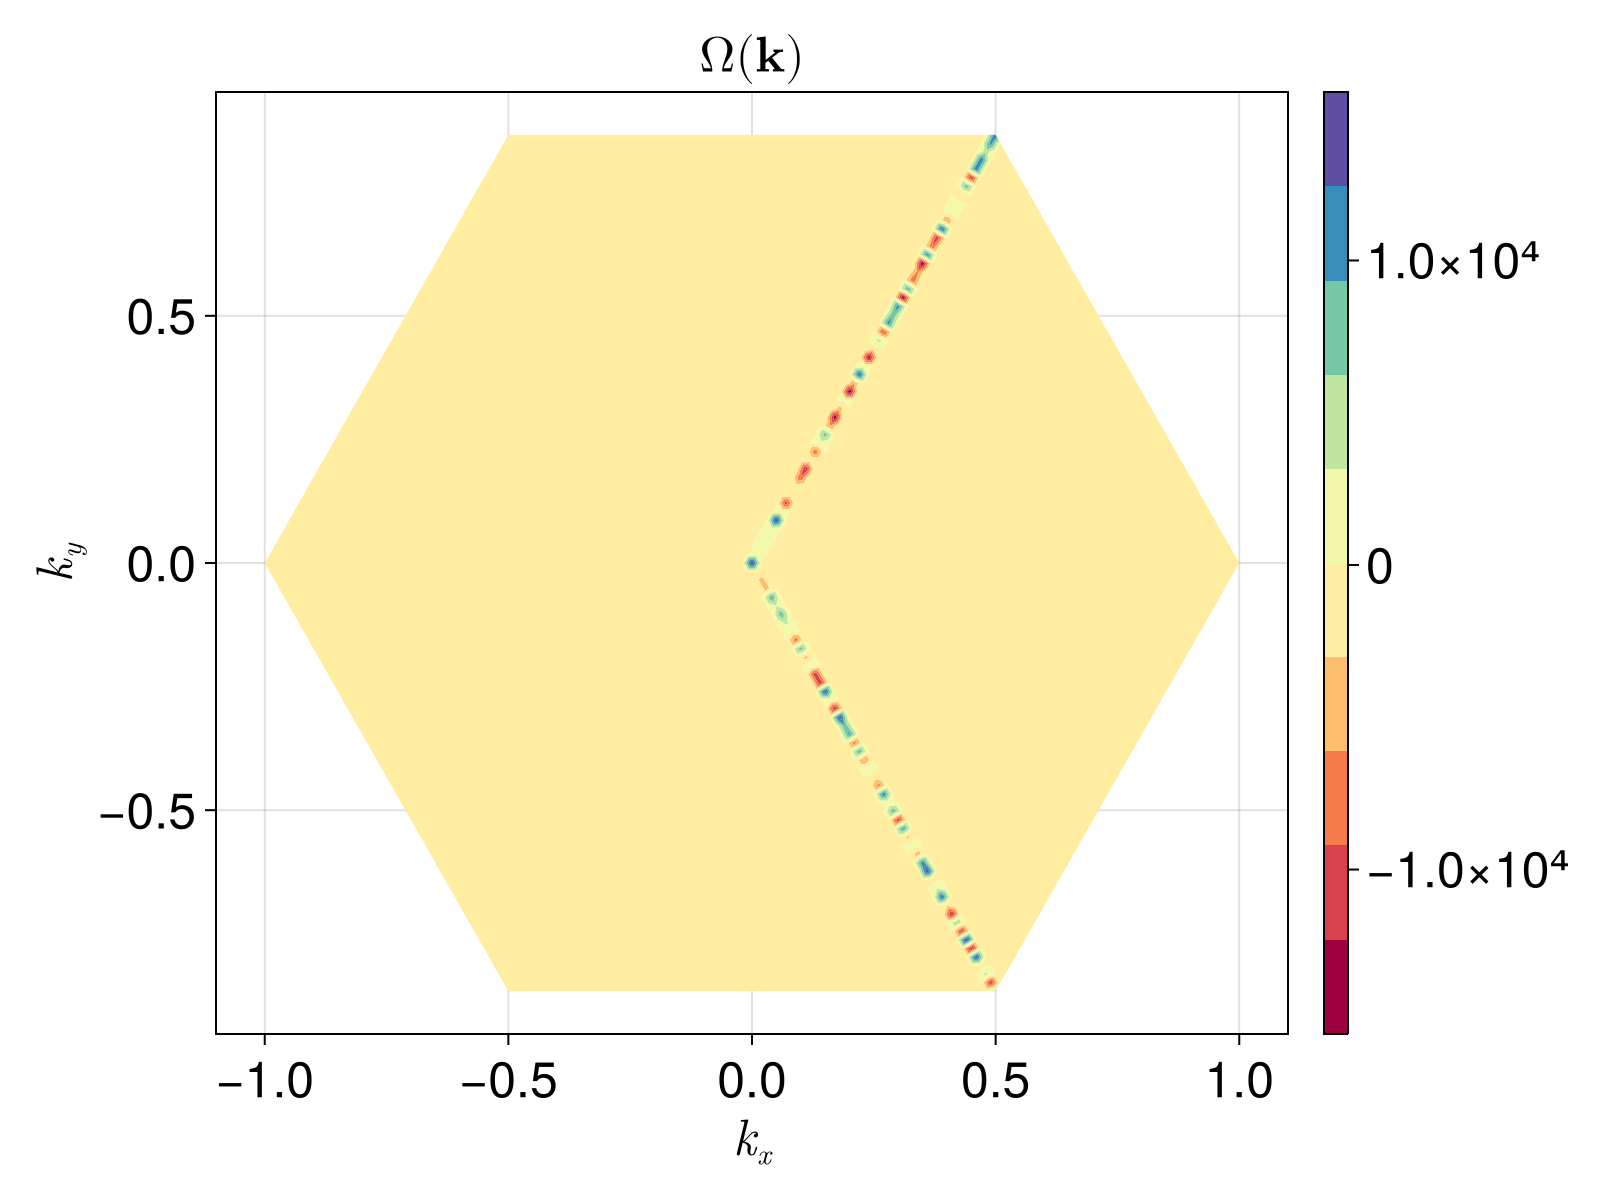

In [15]:
eval_c_hop_bc(qlim, pd, delta)